In [1]:
!nvidia-smi

Thu Dec 22 17:38:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import data
import numpy as np

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dir = '/content/drive/MyDrive/data_sd/train'
valid_dir = '/content/drive/MyDrive/data_sd/val'
test_dir = '/content/drive/MyDrive/data_sd/test'

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2012 files belonging to 36 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 251 files belonging to 36 classes.


In [5]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 252 files belonging to 36 classes.


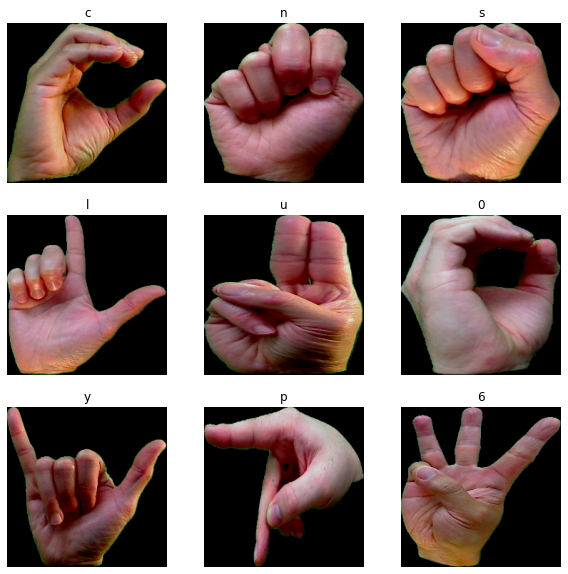

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomContrast(factor=0.7),
  tf.keras.layers.RandomBrightness(factor=0.7),
  tf.keras.layers.RandomRotation(0.1)
])

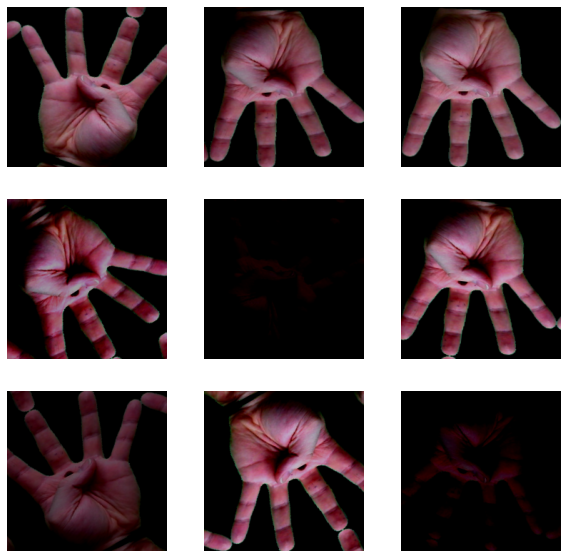

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [13]:
rescale = tf.keras.layers.Rescaling(1./255)

In [14]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [16]:
base_model.trainable = False

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [19]:
prediction_layer = tf.keras.layers.Dense(36)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 36)


In [20]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [23]:
len(model.trainable_variables)

2

In [24]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 43s 185ms/step - loss: 4.0808 - accuracy: 0.0279


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.08
initial accuracy: 0.03


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


63/63 [==============================] - 273s 4s/step - loss: 3.9396 - accuracy: 0.0323 - val_loss: 3.5236 - val_accuracy: 0.0398
Epoch 2/20
63/63 [==============================] - 27s 414ms/step - loss: 3.6340 - accuracy: 0.0577 - val_loss: 3.3123 - val_accuracy: 0.0797
Epoch 3/20
63/63 [==============================] - 27s 418ms/step - loss: 3.3754 - accuracy: 0.0895 - val_loss: 3.1228 - val_accuracy: 0.1394
Epoch 4/20
63/63 [==============================] - 27s 417ms/step - loss: 3.2035 - accuracy: 0.1257 - val_loss: 2.9544 - val_accuracy: 0.2470
Epoch 5/20
63/63 [==============================] - 28s 420ms/step - loss: 3.0884 - accuracy: 0.1486 - val_loss: 2.8106 - val_accuracy: 0.2749
Epoch 6/20
63/63 [==============================] - 27s 419ms/step - loss: 2.9535 - accuracy: 0.1869 - val_loss: 2.6731 - val_accuracy: 0.3426
Epoch 7/20
63/63 [==============================] - 27s 417ms/step - loss: 2.8155 - accuracy: 0.2251 - val_loss: 2.5526 - val_accuracy: 0.3865
Epoch 8/20
6

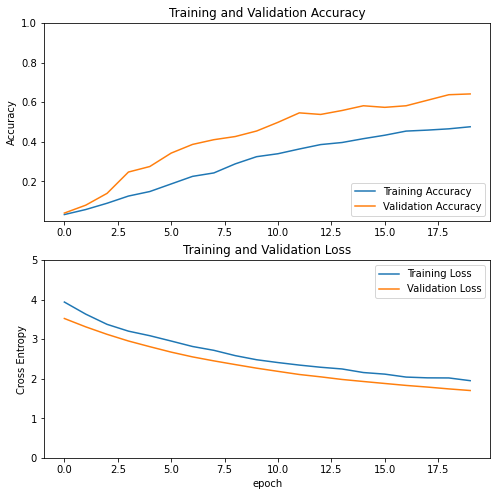

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [30]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [32]:
len(model.trainable_variables)

92

In [33]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40


63/63 [==============================] - 42s 506ms/step - loss: 1.3196 - accuracy: 0.5880 - val_loss: 0.7114 - val_accuracy: 0.7649
Epoch 21/40
63/63 [==============================] - 33s 507ms/step - loss: 1.0255 - accuracy: 0.6804 - val_loss: 0.6350 - val_accuracy: 0.7928
Epoch 22/40
63/63 [==============================] - 31s 481ms/step - loss: 0.9083 - accuracy: 0.7018 - val_loss: 0.4669 - val_accuracy: 0.8327
Epoch 23/40
63/63 [==============================] - 31s 481ms/step - loss: 0.8271 - accuracy: 0.7306 - val_loss: 0.3754 - val_accuracy: 0.8645
Epoch 24/40
63/63 [==============================] - 31s 479ms/step - loss: 0.7373 - accuracy: 0.7614 - val_loss: 0.3250 - val_accuracy: 0.8845
Epoch 25/40
63/63 [==============================] - 31s 481ms/step - loss: 0.6961 - accuracy: 0.7634 - val_loss: 0.2762 - val_accuracy: 0.9044
Epoch 26/40
63/63 [==============================] - 33s 501ms/step - loss: 0.6275 - accuracy: 0.7873 - val_loss: 0.2716 - val_accuracy: 0.9004
Epoc

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

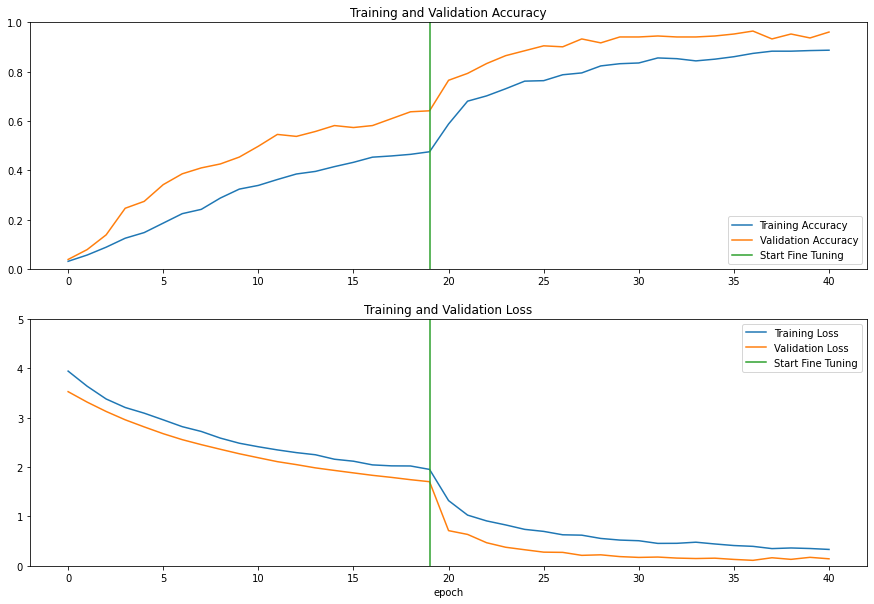

In [35]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 40s 102ms/step - loss: 0.2725 - accuracy: 0.9325
Test accuracy : 0.932539701461792


In [39]:
img_height = 224
img_width = 224

img = tf.keras.utils.load_img(
    '/content/drive/MyDrive/output_ori/nine.jpeg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 120ms/step
This image most likely belongs to 9 with a 95.34 percent confidence.


In [37]:
# from tensorflow.keras.models import load_model

# model.save('transfer_learning_resnet50_v2.h5')